In [2]:
%matplotlib inline

from collections import OrderedDict
import warnings
from copy import deepcopy
import glob
import os
import json
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches

import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, ttest_ind, pearsonr, rankdata
from scipy.signal import detrend
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale

from tqdm import tqdm

import statsmodels.formula.api as smf
from hmmlearn import hmm

import nibabel as nib
from nilearn.plotting import plot_epi,plot_anat,plot_glass_brain,plot_stat_map

from nltools.data import Brain_Data, Adjacency, Design_Matrix
from nltools.stats import (fisher_r_to_z, 
                           downsample, 
                           threshold, 
                           upsample, 
                           zscore, 
                           pearson, 
                           align,
                           winsorize, 
                           fdr, 
                           regress,
                           isc,
                           align_states,
                           circle_shift,
                           _calc_pvalue)
from nltools.mask import expand_mask, collapse_mask
from nltools.plotting import scatterplot

from fnl_tools.stats import (sort_subject_clusters, 
                             calc_fft, 
                             validity_index, 
                             extract_max_timeseries,
                             create_average_concordance,
                             calculate_r_square,
                             align_clusters_groups,
                             group_cluster_consensus,
                             calc_r_square,
                             global_zscore,
                             global_min_max_scaler,
                            )
from fnl_tools.plotting import (plot_raster,
                                plot_recurrence,
                                plot_avg_state_timeseries,
                                plot_wavelet,
                                plot_concordance,
                                frequency_color_func)
from fnl_tools.utils import get_rect_coord, rec_to_time
from fnl_tools.data import create_long_annotation, create_long_character_annotation

from emotioncf import create_sub_by_item_matrix
from emotioncf.cf import NNMF_sgd, Mean, KNN, NNMF_multiplicative

from feat import Fex
from feat.plotting import draw_lineface, draw_muscles, draw_vectorfield, plot_face, predict
from feat.utils import load_h5

from pymer4.models import Lm, Lmer

from wordcloud import WordCloud, get_single_color_func

warnings.filterwarnings('ignore')

base_dir = '/Volumes/Engram/Data/vmpfc'
# base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'

# Run Shared Response Model to identify common latent space across experiments


In [10]:
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'

k = 4
n_components = k
version = 'v3'
analysis = f'HMM_Combined_{version}'
roi = 32
cf_version = 'v3'
var_exp = .9
dilate_samples = 60
episode = 'ep01'

zscore = lambda x: (x - np.mean(x, axis=0)) / np.std(x, axis=0)
center = lambda x: (x - np.mean(x, axis=0))

facet = load_h5('facet.h5')

# Load Concordance Data
if analysis == 'HMM_Combined_v4':
    s1_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study1_k{k}_ROI{roi}_{version}_aligned.csv'), index_col=0)
    s2_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study2_k{k}_ROI{roi}_{version}_aligned.csv'), index_col=0)
elif analysis == 'HMM_Combined_v3':
#     s1_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study1_{episode}_k{k}_ROI{roi}_{version}.csv'), index_col=0)
#     s2_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study2_{episode}_k{k}_ROI{roi}_{version}.csv'), index_col=0)
    s1_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study1_k{k}_ROI{roi}_{version}.csv'), index_col=0)
    s2_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study2_k{k}_ROI{roi}_{version}.csv'), index_col=0)
s1_concordance = zscore(create_average_concordance(s1_dat))
s2_concordance = zscore(create_average_concordance(s2_dat))

# Create average AU by Time
file_list = glob.glob(os.path.join(base_dir,'Analyses','FaceExpression','*_FaceExpression_AU_0.5hz.csv'))
sub_out = []
for f in file_list:
    sub = os.path.basename(f).split('_')[0]
    tmp = center(pd.read_csv(f,index_col=0))
    au_list = tmp.columns
    tmp['Subject']  = sub
    sub_out.append(tmp)
sub_out = pd.concat(sub_out)
sub_out.reset_index(inplace=True, drop=True)
au_mean = {}
for au in list(sub_out.columns[:-1]):
    au_subs = {}
    for sub in sub_out['Subject'].unique():
        au_subs[sub] = sub_out.query('Subject==@sub')[au].values
    au_mean[au] = pd.DataFrame(au_subs).mean(axis=1)
au_mean = zscore(pd.DataFrame(au_mean))

# Create average Rating by Time
file = open(os.path.join(base_dir, 'Data', 'CollaborativeFiltering','sparse.json'), 'r') 
ratings = json.loads(file.read())
all_data = {}
for name in ratings.keys():
    all_data[name] = pd.read_csv(os.path.join(base_dir, 'Data', 'CollaborativeFiltering', f'FNL_EmotionCF_{name}_NNMF_SGD_Dilate{dilate_samples}_{cf_version}.csv'), index_col=0).T
ratings_mean = {}
for emo in all_data:
    ratings_mean[emo] = center(downsample(all_data[emo], sampling_freq=1, target=.5, target_type='hz')).mean(axis=1)
ratings_mean = center(global_zscore(pd.DataFrame(ratings_mean)))

# Train SRM
data = [s1_concordance.values, s2_concordance.values, au_mean.values, ratings_mean.values]
shortest_length = np.min([x.shape[0] for x in data])
data = [x[:shortest_length,:] for x in data]

aligned = align(data, n_features=n_components, method='deterministic_srm')
s1_concord_wt, s2_concord_wt, au_wt, rating_wt = aligned['transformation_matrix']
s1_concord_ts, s2_concord_ts, au_ts, rating_ts = aligned['transformed']
print(aligned['isc'])
pd.Series(aligned['isc']).to_csv(os.path.join(base_dir, 'Analyses', 'Experiment_SRM', f'ISC_k{k}_ROI{roi}.csv'))

# Reorder
reorder_srm = [3,1,2,0]
au_wt = au_wt[:,reorder_srm]
rating_wt = rating_wt[:,reorder_srm]

# Write out each transformation matrix
for i,x in enumerate(aligned['transformation_matrix']):
    pd.DataFrame(x).to_csv(os.path.join(base_dir, 'Analyses', 'Experiment_SRM', f'Study{i+1}_Transformation_Matrix_k{k}_ROI{roi}.csv'))
    
# How much does each study load onto each component
latent_factor_similarity = []
for x in aligned['transformed']:
    latent_factor_similarity.append(np.diag(pd.concat([pd.DataFrame(x.T),pd.DataFrame(aligned['common_model'])], axis=1).corr(), k=k ))
latent_factor_similarity = pd.DataFrame(latent_factor_similarity)
latent_factor_similarity.columns = [f'SRM_{x}' for x in range(k)]
latent_factor_similarity['Study'] = [f'Study_{x}' for x in range(4)]
latent_factor_similarity.to_csv(os.path.join(base_dir, 'Analyses', 'Experiment_SRM', f'Factor_Similarity_k{k}_ROI{roi}.csv'))


{0: 0.2469126612436474, 1: 0.2343285501023876, 2: 0.18631734765173924, 3: 0.26002581602982444}


## Plot SRM Latent Components

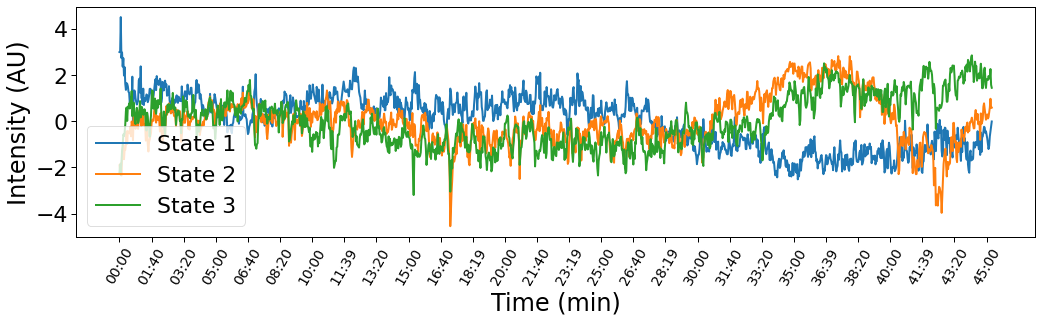

In [3]:
base_dir = '/Volumes/Engram/Data/vmpfc'
with sns.plotting_context(context='paper', font_scale=2.5):
    f,a = plt.subplots(figsize=(15,5))
    a.plot(aligned['common_model'], linewidth=2)
    a.set_xticks(range(0, aligned['common_model'].shape[0], 50))
    a.set_xticklabels(rec_to_time(range(0, aligned['common_model'].shape[0], 50), TR=2.0), rotation=60, fontsize=14)
    a.set_ylabel('Intensity (AU)')
    a.set_xlabel('Time (min)')
    plt.legend([f'State {x+1}' for x in range(n_components)])
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'Figures', 'Experiment_SRM', f'Experiment_SRM_Common_Timeseries_roi{roi}_k{k}_{version}.pdf'))
pd.DataFrame(aligned['common_model']).to_csv(os.path.join(base_dir, 'Figures', analysis, f'Experiment_SRM_Common_Timeseries_roi{roi}_k{k}_{version}.csv'))

## Plot SRM ISC

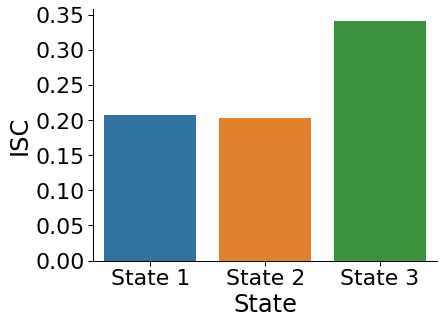

In [4]:
with sns.plotting_context(context='paper', font_scale=2.5):
    isc = pd.DataFrame({'ISC':pd.Series(aligned['isc']).values,'State':[f'State {x+1}' for x in range(k)]})
    sns.catplot(data=isc, y='ISC', x='State', kind='bar', aspect=1.3)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'Figures', 'Experiment_SRM', f'Experiment_SRM_ISC_roi{roi}_k{k}_{version}.pdf'))


In [9]:
print(f"ISC Mean: {np.tanh(fisher_r_to_z(isc['ISC']).mean())}")
print(f"ISC Mean: {np.tanh(fisher_r_to_z(isc['ISC']).std())}")

ISC Mean: 0.25158556264583787
ISC Mean: 0.08524819746096912


In [10]:
isc

ISC    State
0  0.207538  State 1
1  0.202166  State 2
2  0.341445  State 3

## Plot Study specific Projected SRM Components

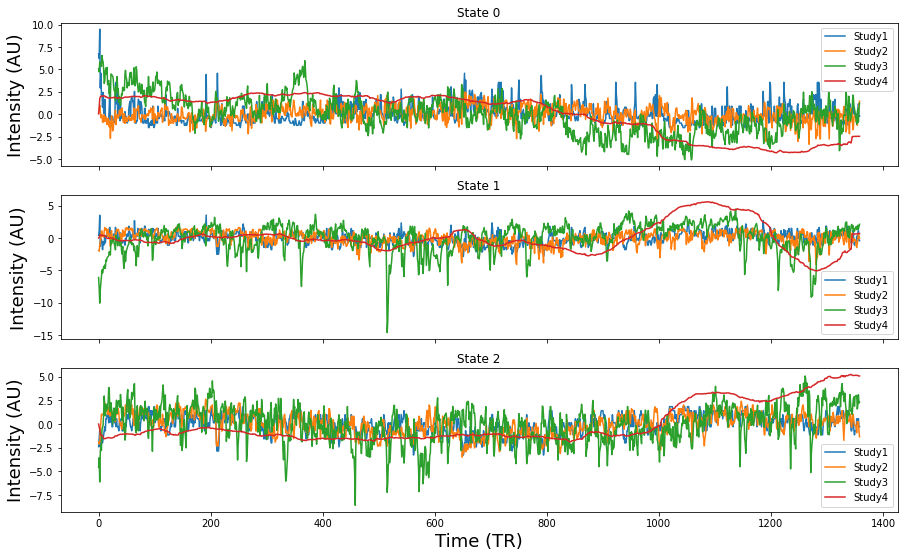

In [5]:
f,a = plt.subplots(nrows=n_components, figsize=(15, 3*n_components), sharex=True)

for i,s in enumerate(range(n_components)):
    pd.DataFrame(np.vstack([s1_concord_ts[s,:], s2_concord_ts[s,:], au_ts[s,:], rating_ts[s,:]]).T, columns=['Study1', 'Study2','Study3','Study4']).plot(ax=a[i])
#     pd.DataFrame(np.vstack([au_ts[s,:], rating_ts[s,:]]).T, columns=['Study3','Study4']).plot(ax=a[i])
    a[i].set_title(f'State {s}')
    a[i].set_ylabel('Intensity (AU)', fontsize=18)
a[i].set_xlabel('Time (TR)', fontsize=18)
plt.savefig(os.path.join(base_dir, 'Figures', 'Experiment_SRM', f'Experiment_SRM_Timeseries_roi{roi}_k{k}_{version}.pdf'))
    

## Plot Face Expression and Rating SRM Loadings

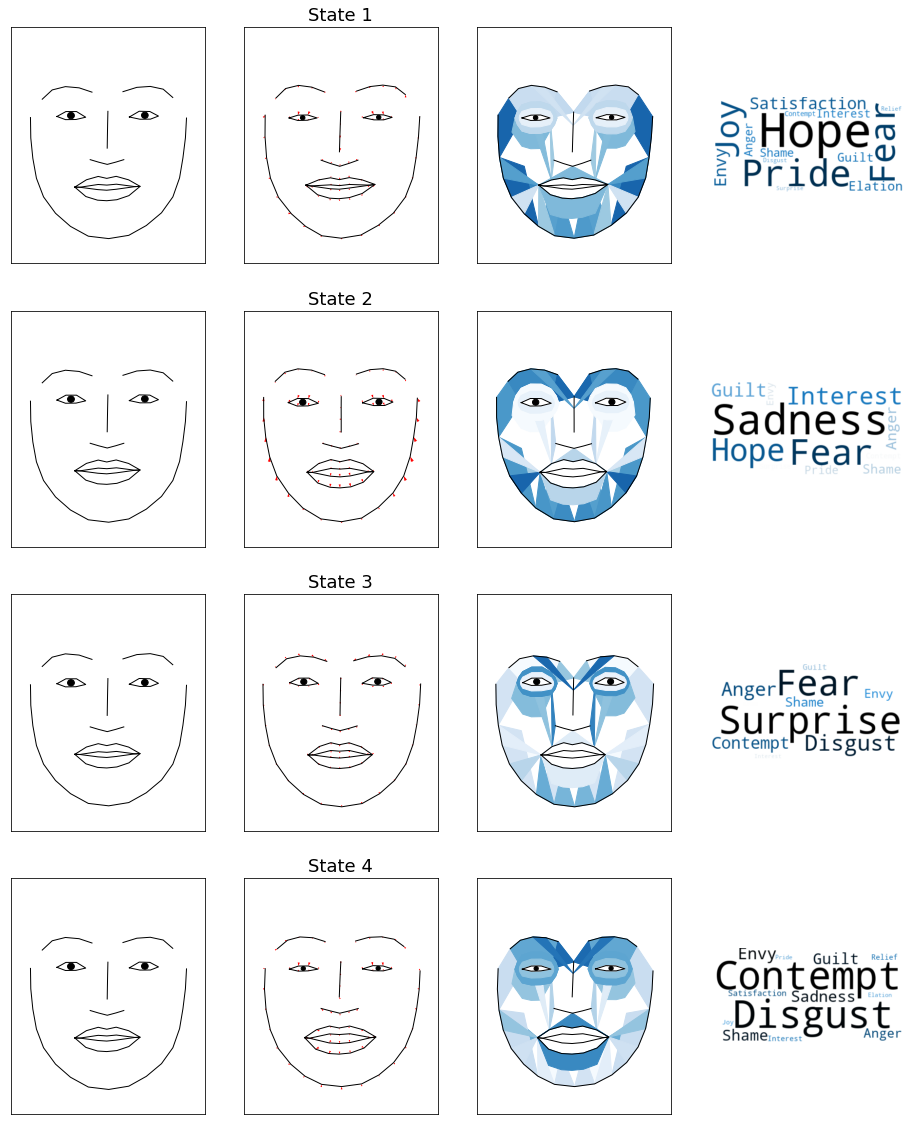

In [13]:
def frequency_color_func(word, hue=205, saturation_scaling=1.2, lightness_scaling=1.2, **kwargs):
    '''color helper function for word cloud plots'''
    return f"hsl({hue}, {saturation_scaling*word_dict[word]}%, {lightness_scaling*(100-word_dict[word])}%)"

f,a = plt.subplots(ncols=4, nrows=n_components, figsize=(16, 5*n_components))
fex = {}
for i,s in enumerate(range(n_components)):
    au = pd.Series(minmax_scale(au_wt[:,s], feature_range=(0,4)), index=list(au_mean.columns))
    au.index = [int(x.split('AU')[1]) for x in au_list]
    fex[s] = np.concatenate([au.sort_index().values, np.zeros(3)])
    muscles = {'all': 'heatmap'}
    neutral = predict(np.zeros(len(fex[s])), facet)
    vectors = {'target': predict(fex[s], facet),
               'reference':  neutral, 'color': 'red'}

    plot_face(au=np.zeros(len(fex[s])), model=facet, ax=a[i,0])
    plot_face(au=fex[s], vectorfield=vectors, model=facet, ax=a[i,1])
    plot_face(au=fex[s], model=facet, muscles=muscles, ax=a[i,2])
    
    word_weights = pd.DataFrame(minmax_scale(rating_wt, feature_range=(0, 100)), index=list(ratings_mean.columns))
    word_dict = dict(word_weights[s].astype(int))
    wc = WordCloud(background_color="white", repeat=False, color_func=frequency_color_func, relative_scaling=1)
    a[i,3].imshow(wc.generate_from_frequencies(word_dict), interpolation="bilinear")
    a[i,3].axis('off')
    a[i,1].set_title(f'State {s+1}', fontsize=18)
plt.savefig(os.path.join(base_dir, 'Figures', 'Experiment_SRM', f'Experiment_SRM_Emotion_roi{roi}_k{k}_{version}.pdf'))

## Plot Face Expressions

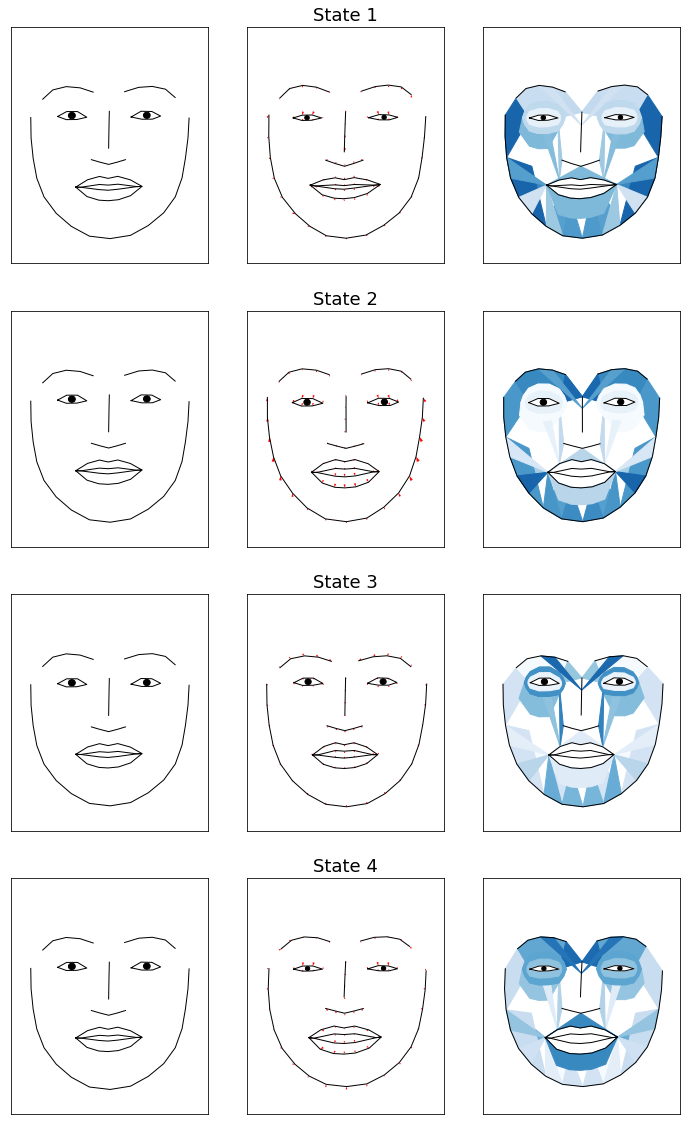

In [26]:
f,a = plt.subplots(ncols=3, nrows=n_components, figsize=(12, 5*n_components))
fex = {}
for i,s in enumerate(range(n_components)):
    au = pd.Series(minmax_scale(au_wt[:,s], feature_range=(0,4)), index=list(au_mean.columns))
    au.index = [int(x.split('AU')[1]) for x in au_list]
    fex[s] = np.concatenate([au.sort_index().values, np.zeros(3)])
    muscles = {'all': 'heatmap'}
    neutral = predict(np.zeros(len(fex[s])), facet)
    vectors = {'target': predict(fex[s], facet),
               'reference':  neutral, 'color': 'red'}

    plot_face(au=np.zeros(len(fex[s])), model=facet, ax=a[i,0])
    plot_face(au=fex[s], vectorfield=vectors, model=facet, ax=a[i,1])
    plot_face(au=fex[s], model=facet, muscles=muscles, ax=a[i,2])
    
    a[i,1].set_title(f'State {s+1}', fontsize=18)
plt.savefig(os.path.join(base_dir, 'Figures', 'Experiment_SRM', f'Experiment_SRM_FaceExpression_roi{roi}_k{k}_{version}.pdf'))
plt.savefig(os.path.join(base_dir, 'Figures', 'Experiment_SRM', f'Experiment_SRM_FaceExpression_roi{roi}_k{k}_{version}.png'), dpi=300)


## Plot Emotion Ratings

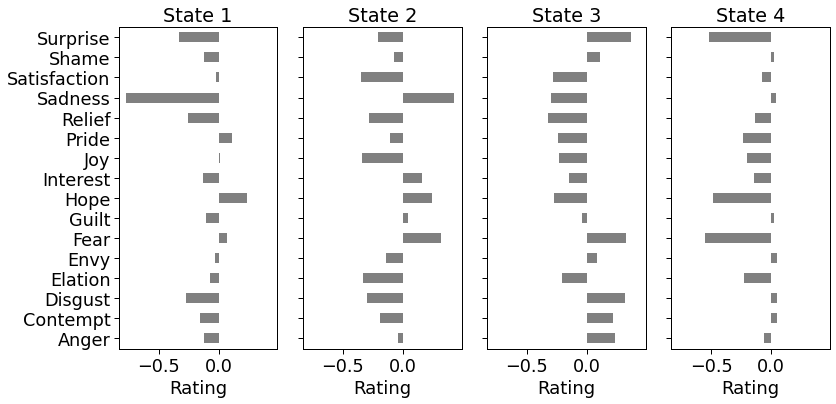

In [24]:
with sns.plotting_context(context='paper', font_scale=2):
    f,a = plt.subplots(ncols=k, figsize=(3*k, 6), sharex=True, sharey=True)
    weights = {}
    for i,s in enumerate(range(k)):
        weights[s] = pd.Series(rating_wt[:,s], index=ratings_mean.columns)
#         models[s].coefs['Estimate'].iloc[1:].plot(kind='barh', legend=False, color='grey', ax=a[i])
        weights[s].plot(kind='barh', legend=False, color='grey', ax=a[i])
        a[i].set_title(f'State {s+1}')
        a[i].set_xlabel('Rating', fontsize=18)
    a[0].yaxis.tick_left()
    a[0].set_ylabel('')

    plt.tight_layout()
    plt.savefig(os.path.join(base_dir,'Figures','Experiment_SRM', f'Experiment_SRM_Emotion_Rating_k{k}_roi{roi}.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures','Experiment_SRM', f'Experiment_SRM_Emotion_Rating_k{k}_roi{roi}.png'), dpi=300)

#     weights = pd.DataFrame(weights)
#     weights.to_csv(os.path.join(base_dir,'Analyses','RatingsStateRegression', f'Emotion_Rating_{study}_k{k}_roi{roi}.csv'))

## Plot State Concordance SRM Loadings

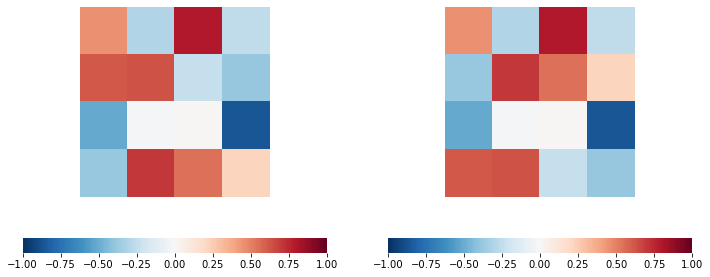

In [114]:
k = 4
n_components = k
version = 'v3'
analysis = f'HMM_Combined_{version}'
roi = 32
cf_version = 'v3'
var_exp = .9
dilate_samples = 60


s1_concord = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study1_k{k}_ROI{roi}_{version}.csv'), index_col=0))
s2_concord = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study2_k{k}_ROI{roi}_{version}.csv'), index_col=0))
common_model = pd.read_csv(os.path.join(base_dir, 'Figures', analysis, f'Experiment_SRM_Common_Timeseries_k{k}_{version}.csv'), index_col=0)

s2_aligned_idx = pd.DataFrame(align_states(s1_concord, s2_concord, replace_zero_variance=True, return_index=True))
# Rearrange components
reorder_srm = [3,1,2,0]
reorder_hmm = [0,3,2,1]
s1_concord_wt = s1_concord_wt[:, reorder_srm] # reorder HMM states
s2_concord_wt = s2_concord_wt[:, reorder_srm] # reorder HMM states
s2_concord_wt = s2_concord_wt[s2_aligned_idx.iloc[:,0].values, :] # Reorder S2 concordance to match S1
s1_concord_wt = s1_concord_wt[reorder_hmm,:] # reorder S1 to match HMM
s2_concord_wt = s1_concord_wt[reorder_hmm,:] # reorder S2 to match HMM


f,a = plt.subplots(ncols=2, figsize=(12,5), sharey=True)
sns.heatmap(s1_concord_wt, cmap='RdBu_r', ax=a[0], vmin=-1, vmax=1, square=True, cbar_kws={'orientation': 'horizontal'})
sns.heatmap(s2_concord_wt, cmap='RdBu_r', ax=a[1], vmin=-1, vmax=1, square=True, cbar_kws={'orientation': 'horizontal'})
a[0].set_ylabel('HMM State Concordance', fontsize=18)
a[0].set_xlabel('Shared Component', fontsize=18)
a[1].set_xlabel('Shared Component', fontsize=18)
a[0].axis('off')
a[1].axis('off')
plt.savefig(os.path.join(base_dir, 'Figures', 'Experiment_SRM', f'Experiment_SRM_HMM_Weights_k{k}_{version}.pdf'))

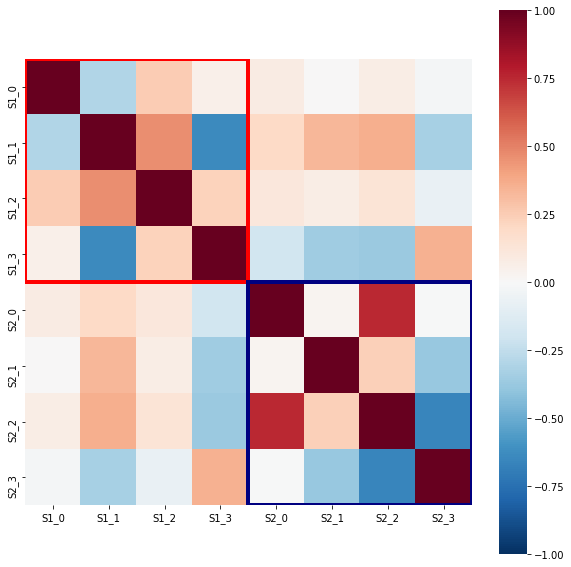

In [51]:
f,a = plt.subplots(figsize=(10,10))
# sns.heatmap(1 - pairwise_distances(np.concatenate([s1_concord_ts.T, s2_concord_ts.T], axis=1).T, metric='correlation'),
sns.heatmap(1 - pairwise_distances(np.concatenate([s1_concord_ts.T, s2_concord_ts.T], axis=1).T, metric='correlation'),
            cmap='RdBu_r', vmin=-1, vmax=1, xticklabels=[f'S1_{i}' for i in range(k)] + [f'S2_{i}' for i in range(k)],
           yticklabels=[f'S1_{i}' for i in range(k)] + [f'S2_{i}' for i in range(k)], square=True, ax=a)
rect = patches.Rectangle((0,0), 4, 4, linewidth=4, edgecolor='red', facecolor='none')
a.add_patch(rect)
rect = patches.Rectangle((4,4), 4, 4, linewidth=4, edgecolor='navy', facecolor='none')
a.add_patch(rect)
plt.savefig(os.path.join(base_dir, 'Figures', 'Experiment_SRM', f'Brain_Experiments_HMM_Concordance_k{k}_ROI{roi}_{version}.pdf'))

# How much does each study load onto component?

In [105]:
isc = {}
factor_sim = {}
factor_sim_long = []
for roi in [4,19,32]:
    isc[roi] = pd.read_csv(glob.glob(os.path.join(base_dir, 'Analyses', 'Experiment_SRM', f'ISC_k*_ROI{roi}.csv'))[0], index_col=0)
    isc[roi].columns = ['ISC']
    isc[roi]['ROI'] = roi
    isc[roi]['State'] = [f'State_{x}' for x in isc[roi].index]
    factor_sim[roi] = pd.read_csv(glob.glob(os.path.join(base_dir, 'Analyses', 'Experiment_SRM', f'Factor_Similarity_k*_ROI{roi}.csv'))[0], index_col=0)
    long = factor_sim[roi].melt(id_vars='Study', value_name='Similarity', var_name='Component')
    long['ROI'] = roi 
    factor_sim_long.append(long)
isc_long = pd.concat([isc[x] for x in isc])
factor_sim_long = pd.concat(factor_sim_long)
factor_sim_long.reset_index(inplace=True, drop=True)


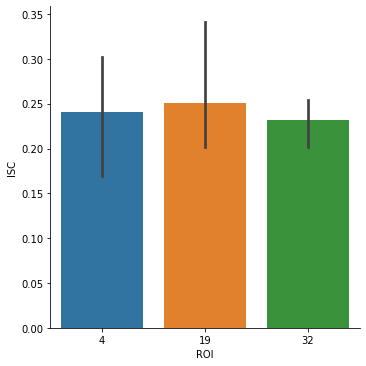

In [100]:
sns.catplot(data=isc_long, x='ROI', y='ISC', kind='bar') 

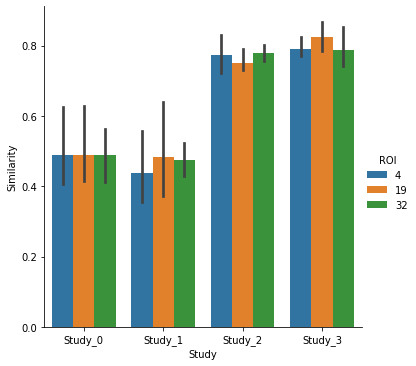

In [99]:

sns.catplot(data=factor_sim_long, x='Study', hue='ROI', y='Similarity', kind='bar') 

In [108]:
factor_sim_long.query('Study=="Study_1"')

Study Component  Similarity  ROI
1   Study_1     SRM_0    0.399312    4
5   Study_1     SRM_1    0.353907    4
9   Study_1     SRM_2    0.556903    4
13  Study_1     SRM_0    0.371950   19
17  Study_1     SRM_1    0.438406   19
21  Study_1     SRM_2    0.638501   19
25  Study_1     SRM_0    0.486723   32
29  Study_1     SRM_1    0.451587   32
33  Study_1     SRM_2    0.408726   32
37  Study_1     SRM_3    0.546535   32

# Examine ROI Transformation Matrices

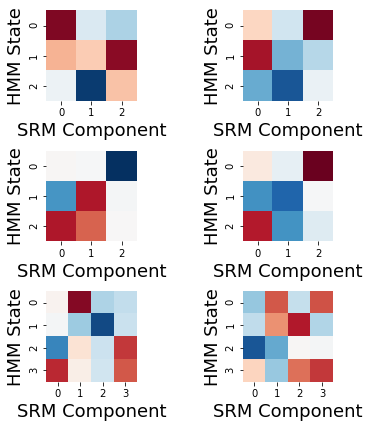

In [132]:
s1_transform = {}
s2_transform = {}
for roi in [4,19,32]:
    s1_transform[roi] = pd.read_csv(glob.glob(os.path.join(base_dir, 'Analyses', 'Experiment_SRM', f'Study1_Transformation_Matrix_k*_ROI{roi}.csv'))[0], index_col=0)
    s2_transform[roi] = pd.read_csv(glob.glob(os.path.join(base_dir, 'Analyses', 'Experiment_SRM', f'Study2_Transformation_Matrix_k*_ROI{roi}.csv'))[0], index_col=0)

f,a = plt.subplots(ncols=2, nrows=3, figsize=(6,6))
for i,roi in enumerate([4,19,32]):
    sns.heatmap(s1_transform[roi], cmap='RdBu_r', ax=a[i,0], vmin=-1, vmax=1, square=True, cbar=False)
    sns.heatmap(s2_transform[roi], cmap='RdBu_r', ax=a[i,1], vmin=-1, vmax=1, square=True, cbar=False)
    a[i,0].set_ylabel('HMM State', fontsize=18)
    a[i,1].set_ylabel('HMM State', fontsize=18)
    a[i,0].set_xlabel('SRM Component', fontsize=18)
    a[i,1].set_xlabel('SRM Component', fontsize=18)
plt.tight_layout()
#     a[i,0].axis('off')
#     a[i,1].axis('off')
  

In [ ]:
k = 4
n_components = k
version = 'v3'
analysis = f'HMM_Combined_{version}'
roi = 32
cf_version = 'v3'
var_exp = .9
dilate_samples = 60


s1_concord = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study1_{episode}_k{k}_ROI{roi}_{version}.csv'), index_col=0))
s2_concord = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study2_{episode}_k{k}_ROI{roi}_{version}.csv'), index_col=0))
common_model = pd.read_csv(os.path.join(base_dir, 'Figures', analysis, f'Experiment_SRM_Common_Timeseries_k{k}_{version}.csv'), index_col=0)

s2_aligned_idx = pd.DataFrame(align_states(s1_concord, s2_concord, replace_zero_variance=True, return_index=True))
# Rearrange components
reorder_srm = [3,1,2,0]
reorder_hmm = [0,3,2,1]
s1_concord_wt = s1_concord_wt[:, reorder_srm] # reorder HMM states
s2_concord_wt = s2_concord_wt[:, reorder_srm] # reorder HMM states
s2_concord_wt = s2_concord_wt[s2_aligned_idx.iloc[:,0].values, :] # Reorder S2 concordance to match S1
s1_concord_wt = s1_concord_wt[reorder_hmm,:] # reorder S1 to match HMM
s2_concord_wt = s1_concord_wt[reorder_hmm,:] # reorder S2 to match HMM


f,a = plt.subplots(ncols=2, figsize=(12,5), sharey=True)
sns.heatmap(s1_concord_wt, cmap='RdBu_r', ax=a[0], vmin=-1, vmax=1, square=True, cbar_kws={'orientation': 'horizontal'})
sns.heatmap(s2_concord_wt, cmap='RdBu_r', ax=a[1], vmin=-1, vmax=1, square=True, cbar_kws={'orientation': 'horizontal'})
a[0].set_ylabel('HMM State Concordance', fontsize=18)
a[0].set_xlabel('Shared Component', fontsize=18)
a[1].set_xlabel('Shared Component', fontsize=18)
a[0].axis('off')
a[1].axis('off')
plt.savefig(os.path.join(base_dir, 'Figures', 'Experiment_SRM', f'Experiment_SRM_HMM_Weights_k{k}_{version}.pdf'))

# Map State Concordance on to features

In [16]:
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'

version = 'v3'
analysis = f'HMM_Combined_{version}'
cf_version = 'v3'
var_exp = .9
dilate_samples = 60
episode = 'ep01'

zscore = lambda x: (x - np.mean(x, axis=0)) / np.std(x, axis=0)
center = lambda x: (x - np.mean(x, axis=0))


# Create average AU by Time
facet = load_h5('facet.h5')
file_list = glob.glob(os.path.join(base_dir,'Analyses','FaceExpression','*_FaceExpression_AU_0.5hz.csv'))
sub_out = []
for f in file_list:
    sub = os.path.basename(f).split('_')[0]
    tmp = center(pd.read_csv(f,index_col=0))
    au_list = tmp.columns
    tmp['Subject']  = sub
    sub_out.append(tmp)
sub_out = pd.concat(sub_out)
sub_out.reset_index(inplace=True, drop=True)
au_mean = {}
for au in list(sub_out.columns[:-1]):
    au_subs = {}
    for sub in sub_out['Subject'].unique():
        au_subs[sub] = sub_out.query('Subject==@sub')[au].values
    au_mean[au] = pd.DataFrame(au_subs).mean(axis=1)
# au_mean = pd.DataFrame(au_mean)
au_mean = zscore(pd.DataFrame(au_mean))

# Create average Rating by Time
file = open(os.path.join(base_dir, 'Data', 'CollaborativeFiltering','sparse.json'), 'r') 
ratings = json.loads(file.read())
all_data = {}
for name in ratings.keys():
    all_data[name] = pd.read_csv(os.path.join(base_dir, 'Data', 'CollaborativeFiltering', f'FNL_EmotionCF_{name}_NNMF_SGD_Dilate{dilate_samples}_{cf_version}.csv'), index_col=0).T
ratings_mean = {}
for emo in all_data:
    ratings_mean[emo] = center(downsample(all_data[emo], sampling_freq=1, target=.5, target_type='hz')).mean(axis=1)
ratings_mean = center(global_zscore(pd.DataFrame(ratings_mean)))
# ratings_mean = pd.DataFrame(ratings_mean)

# Load Visual Features
visual_features = pd.read_csv(os.path.join(base_dir,'Analyses','FeatureExtraction',f'FNL_{episode}_Visual_Features.csv'), index_col=0)
visual_features = zscore(visual_features[['BrightnessExtractor#brightness','VibranceExtractor#vibrance']])
visual_features.columns = ['Brightness', 'Vibrance']

# Load Concordances
v1_s1_concordance = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study1_{episode}_k3_ROI4_{version}.csv'), index_col=0))
v1_s1_concordance.columns = [f'Study1_ROI4_{x}' for x in v1_s1_concordance.columns]
v1_s2_concordance = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study2_{episode}_k3_ROI4_{version}.csv'), index_col=0))
v1_s2_concordance.columns = [f'Study2_ROI4_{x}' for x in v1_s2_concordance.columns]

vmpfc_s1_concordance = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study1_{episode}_k4_ROI32_{version}.csv'), index_col=0))
vmpfc_s1_concordance.columns = [f'Study1_ROI32_{x}' for x in vmpfc_s1_concordance.columns]
vmpfc_s2_concordance = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study2_{episode}_k4_ROI32_{version}.csv'), index_col=0))
vmpfc_s2_concordance.columns = [f'Study2_ROI32_{x}' for x in vmpfc_s2_concordance.columns]

pcc_s1_concordance = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study1_{episode}_k3_ROI19_{version}.csv'), index_col=0))
pcc_s1_concordance.columns = [f'Study1_ROI19_{x}' for x in pcc_s1_concordance.columns]
pcc_s2_concordance = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study2_{episode}_k3_ROI19_{version}.csv'), index_col=0))
pcc_s2_concordance.columns = [f'Study2_ROI19_{x}' for x in pcc_s2_concordance.columns]


features = pd.concat([vmpfc_s1_concordance, vmpfc_s2_concordance, v1_s1_concordance, v1_s2_concordance, pcc_s1_concordance, pcc_s2_concordance, visual_features, ratings_mean, au_mean], axis=1)
features = features.dropna()

convolved_features = Design_Matrix(features.iloc[:,20:], sampling_freq=1/2.0).convolve()
convolved_features.columns = [x.split('_')[0] for x in convolved_features.columns]



## Correlations with each feature (circle shifted null distribution)

In [52]:

study = 'Study1'
roi = 4
state = 0
n_permute = 5000
roi_states = {4:3, 19:3, 32:4}

feature_correlations = []
for feature in tqdm(['Brightness','Vibrance', 'Anger', 'Contempt', 'Disgust', 
                'Elation', 'Envy', 'Fear','Guilt', 'Hope', 'Interest', 
                'Joy', 'Pride', 'Relief', 'Sadness','Satisfaction', 
                'Shame', 'Surprise', 'AU14', 'AU10', 'AU24', 'AU26','AU15', 
                'AU17', 'AU25', 'AU23', 'AU18', 'AU12', 'AU20', 'AU5', 'AU28',
                'AU9', 'AU2', 'AU43', 'AU6', 'AU4', 'AU1', 'AU7']):
    for study in ['Study1', 'Study2']:
        for roi in [4,19,32]:
            for state in range(roi_states[roi]):
                r,p = pearsonr(features[f'{study}_ROI{roi}_State_{state}'], convolved_features[feature])

                r_null = []
                for i in range(n_permute):
                    r_null.append(pearsonr(features[f'{study}_ROI{roi}_State_{state}'], circle_shift(convolved_features[feature]))[0])
                p = _calc_pvalue(np.array(r_null), r, tail=2)   
                feature_dict = {'Study':study, 'ROI':roi, 'State':f'State_{state}', 
                                'Feature':feature, 'Correlation':r, 'P-Value':p,
                                'CI_Lower':np.percentile(np.array(r_null),2.5), 
                                'CI_Upper':np.percentile(np.array(r_null),97.5)}
                feature_correlations.append(feature_dict)
feature_correlations = pd.DataFrame(feature_correlations)
feature_correlations.to_csv(os.path.join(base_dir, 'Analyses', 'FeatureExtraction',f'State_Concordance_Feature_Correlation_CircleShift_{version}.csv'))


100%|██████████| 38/38 [08:26<00:00, 13.34s/it]


## Contrast of State OnOff for each Feature (circle shifted null distribution)

In [75]:

study = 'Study1'
roi = 4
state = 0
n_permute = 5000
roi_states = {4:3, 19:3, 32:4}
thresh = 0.7

feature_contrasts = []
for feature in tqdm(['Brightness','Vibrance', 'Anger', 'Contempt', 'Disgust', 
                'Elation', 'Envy', 'Fear','Guilt', 'Hope', 'Interest', 
                'Joy', 'Pride', 'Relief', 'Sadness','Satisfaction', 
                'Shame', 'Surprise', 'AU14', 'AU10', 'AU24', 'AU26','AU15', 
                'AU17', 'AU25', 'AU23', 'AU18', 'AU12', 'AU20', 'AU5', 'AU28',
                'AU9', 'AU2', 'AU43', 'AU6', 'AU4', 'AU1', 'AU7']):
    for study in ['Study1', 'Study2']:
        for roi in [4,19,32]:
            for state in range(roi_states[roi]):
                state_on = convolved_features[feature][features[f'{study}_ROI{roi}_State_{state}'] >= thresh].mean()
                state_off = convolved_features[feature][features[f'{study}_ROI{roi}_State_{state}'] < thresh].mean()
                contrast = state_on - state_off
                contrast_null = []
                for i in range(n_permute):
                    circle_shifted_feature = circle_shift(features[f'{study}_ROI{roi}_State_{state}'])
                    state_on_null = convolved_features[feature][circle_shifted_feature >= thresh].mean()
                    state_off_null = convolved_features[feature][circle_shifted_feature < thresh].mean()
                    contrast_null.append(state_on_null - state_off_null)
                p = _calc_pvalue(np.array(contrast_null), contrast, tail=2)   
                feature_dict = {'Study':study, 'ROI':roi, 'State':f'State_{state}', 
                                'Feature':feature, 'Contrast':contrast, 'P-Value':p,
                                'CI_Lower':np.percentile(np.array(contrast_null),2.5), 
                                'CI_Upper':np.percentile(np.array(contrast_null),97.5)}
                feature_contrasts.append(feature_dict)
feature_contrasts = pd.DataFrame(feature_contrasts)
feature_contrasts.to_csv(os.path.join(base_dir, 'Analyses', 'FeatureExtraction',f'State_Concordance_Feature_OnOff_Contrasts_CircleShift_{version}.csv'))


100%|██████████| 38/38 [15:36<00:00, 24.66s/it]


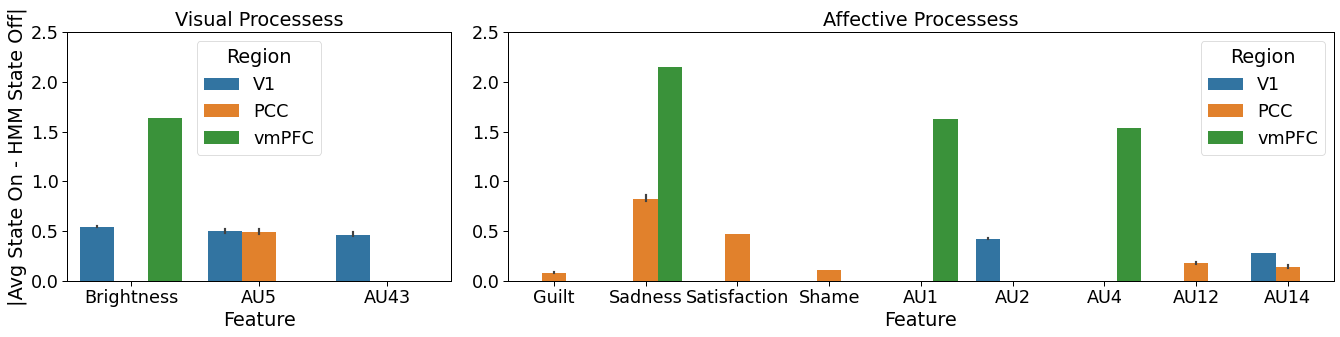

In [321]:
base_dir = '/Volumes/Engram/Data/vmpfc/'

feature_contrasts = pd.read_csv(os.path.join(base_dir, 'Analyses', 'FeatureExtraction',f'State_Concordance_Feature_OnOff_Contrasts_CircleShift_{version}.csv'), index_col=0)
feature_contrasts = feature_contrasts.dropna()

v1_s2_remapping = {f'State_{i}':f'State_{x}' for i,x in enumerate(align_states(v1_s1_concordance, v1_s2_concordance, return_index=True))}
pcc_s2_remapping = {f'State_{i}':f'State_{x}' for i,x in enumerate(align_states(pcc_s1_concordance, pcc_s2_concordance, return_index=True))}
vmpfc_s2_remapping = {f'State_{i}':f'State_{x}' for i,x in enumerate(align_states(vmpfc_s1_concordance, vmpfc_s2_concordance, return_index=True))}
vmpfc_s1_remapping = {'State_0':'State_1','State_1':'State_3','State_2':'State_2','State_3':'State_0'}

s1 = feature_contrasts.query('Study=="Study1"')
v1_tmp = feature_contrasts.query('Study=="Study2"&ROI==4')
v1_tmp['State'] = v1_tmp['State'].replace(v1_s2_remapping)
pcc_tmp = feature_contrasts.query('Study=="Study2"&ROI==19')
pcc_tmp['State'] = pcc_tmp['State'].replace(pcc_s2_remapping)
vmpfc_tmp = feature_contrasts.query('Study=="Study2"&ROI==32')
vmpfc_tmp['State'] = vmpfc_tmp['State'].replace(vmpfc_s2_remapping)
vmpfc_tmp['State'] = vmpfc_tmp['State'].replace(vmpfc_s1_remapping)
s1_vmpfc = feature_contrasts.query('Study=="Study1"&ROI==32')
s1_vmpfc['State'] = s1_vmpfc['State'].replace(vmpfc_s1_remapping)
s1 = pd.concat([feature_contrasts.query('Study=="Study1"&ROI==4'), feature_contrasts.query('Study=="Study1"&ROI==19'), s1_vmpfc])

for roi in [4,19,32]:
    tmp = feature_contrasts.query('Study=="Study2"&ROI==@roi')
    tmp['State'] = tmp['State'].replace(vmpfc_s2_remapping)
    s2.append(tmp)
feature_contrasts = pd.concat([s1,pd.concat(s2)])
feature_contrasts['Contrast_Abs'] = np.abs(feature_contrasts['Contrast'])
roi_mapping = {4:'V1',19:'PCC',32:'vmPFC'}
feature_contrasts['Region'] = feature_contrasts['ROI'].replace(roi_mapping)
vmpfc_remapping = {0:1,1:3,2:2,3:0}

feature_contrasts['Condition'] = [f'{x}_{y}_{z}' for x,y,z in zip(feature_contrasts['Region'], feature_contrasts['State'], feature_contrasts['Feature'])]
feature_contrasts['Condition_State'] = [f'{x}_{y}' for x,y in zip(feature_contrasts['Feature'], feature_contrasts['State'])]
sig_condition = feature_contrasts.loc[feature_contrasts['P-Value'] < 0.05,'Condition'].unique()
visual_features = ['Brightness', 'Vibrance', 'AU43','AU5']
visual_feature_contrasts = feature_contrasts.loc[feature_contrasts['Feature'].isin(visual_features)]
nonvisual_feature_contrasts = feature_contrasts.loc[~feature_contrasts['Feature'].isin(visual_features)]

with sns.plotting_context(context='paper', font_scale=2):
    f = plt.figure(constrained_layout=True, figsize=(19,5))
    gs = f.add_gridspec(1, 3)
    f_a1 = f.add_subplot(gs[0, 0])
    f_a2 = f.add_subplot(gs[0, 1:])
    sns.barplot(y='Contrast_Abs', x='Feature', hue='Region', ax=f_a1,
                data=visual_feature_contrasts.loc[visual_feature_contrasts['Condition'].isin(sig_condition)], orient='vertical')
    sns.barplot(y='Contrast_Abs', x='Feature', hue='Region', ax=f_a2,
                order=['Guilt','Sadness','Satisfaction','Shame', 'AU1','AU2','AU4','AU12','AU14'],
                data=nonvisual_feature_contrasts.loc[nonvisual_feature_contrasts['Condition'].isin(sig_condition)], orient='vertical')
    f_a1.set_ylabel('|Avg State On - HMM State Off|')
    f_a2.set_ylabel('')
    f_a1.set_ylim([0,2.5])
    f_a2.set_ylim([0,2.5])
    f_a1.set_title("Visual Processess")
    f_a2.set_title("Affective Processess")
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'Figures', 'FeatureExtraction','Feature_Contrast_Significant_StateAvg_Abs.pdf'))
    plt.savefig(os.path.join(base_dir, 'Figures', 'FeatureExtraction','Feature_Contrast_Significant_StateAvg_Abs.png'),dpi=150)


In [231]:
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'

study = 'Study1'
roi = 4
state = 0
n_permute = 5000
roi_states = {4:3, 19:3, 32:4}

feature = 'Brightness'

feature_contrasts = []
for feature in tqdm(['Brightness','Vibrance', 'Anger', 'Contempt', 'Disgust', 
                'Elation', 'Envy', 'Fear','Guilt', 'Hope', 'Interest', 
                'Joy', 'Pride', 'Relief', 'Sadness','Satisfaction', 
                'Shame', 'Surprise', 'AU14', 'AU10', 'AU24', 'AU26','AU15', 
                'AU17', 'AU25', 'AU23', 'AU18', 'AU12', 'AU20', 'AU5', 'AU28',
                'AU9', 'AU2', 'AU43', 'AU6', 'AU4', 'AU1', 'AU7']):
    for study in ['Study1', 'Study2']:
        for roi in [4,19,32]:
            predicted_states = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_{study}_{episode}_k{roi_states[roi]}_ROI{roi}_{version}.csv'), index_col=0)
            sub_list = predicted_states['Subject'].unique()
            states = predicted_states['Viterbi'].unique()
            for sub in sub_list:
                sub_predicted_states = predicted_states.query('Subject==@sub').iloc[:convolved_features.shape[0],:]
                for state in states:
                    state_on = convolved_features[feature][sub_predicted_states['Viterbi']==state].mean()
                    state_off = convolved_features[feature][sub_predicted_states['Viterbi']!=state].mean()
                    contrast = state_on - state_off
                    feature_dict = {'Study':study, 'ROI':roi, 'Subject':sub, 'State':f'State_{state}', 
                                    'Feature':feature, 'Contrast':contrast}
                    feature_contrasts.append(feature_dict)
feature_contrasts = pd.DataFrame(feature_contrasts)
feature_contrasts.to_csv(os.path.join(base_dir, 'Analyses', 'FeatureExtraction',f'GroupHMM_State_Feature_OnOff_Contrasts_{version}.csv'))


100%|██████████| 38/38 [00:44<00:00,  1.17s/it]


## Plot V1 Concordance w/ Convolved Features


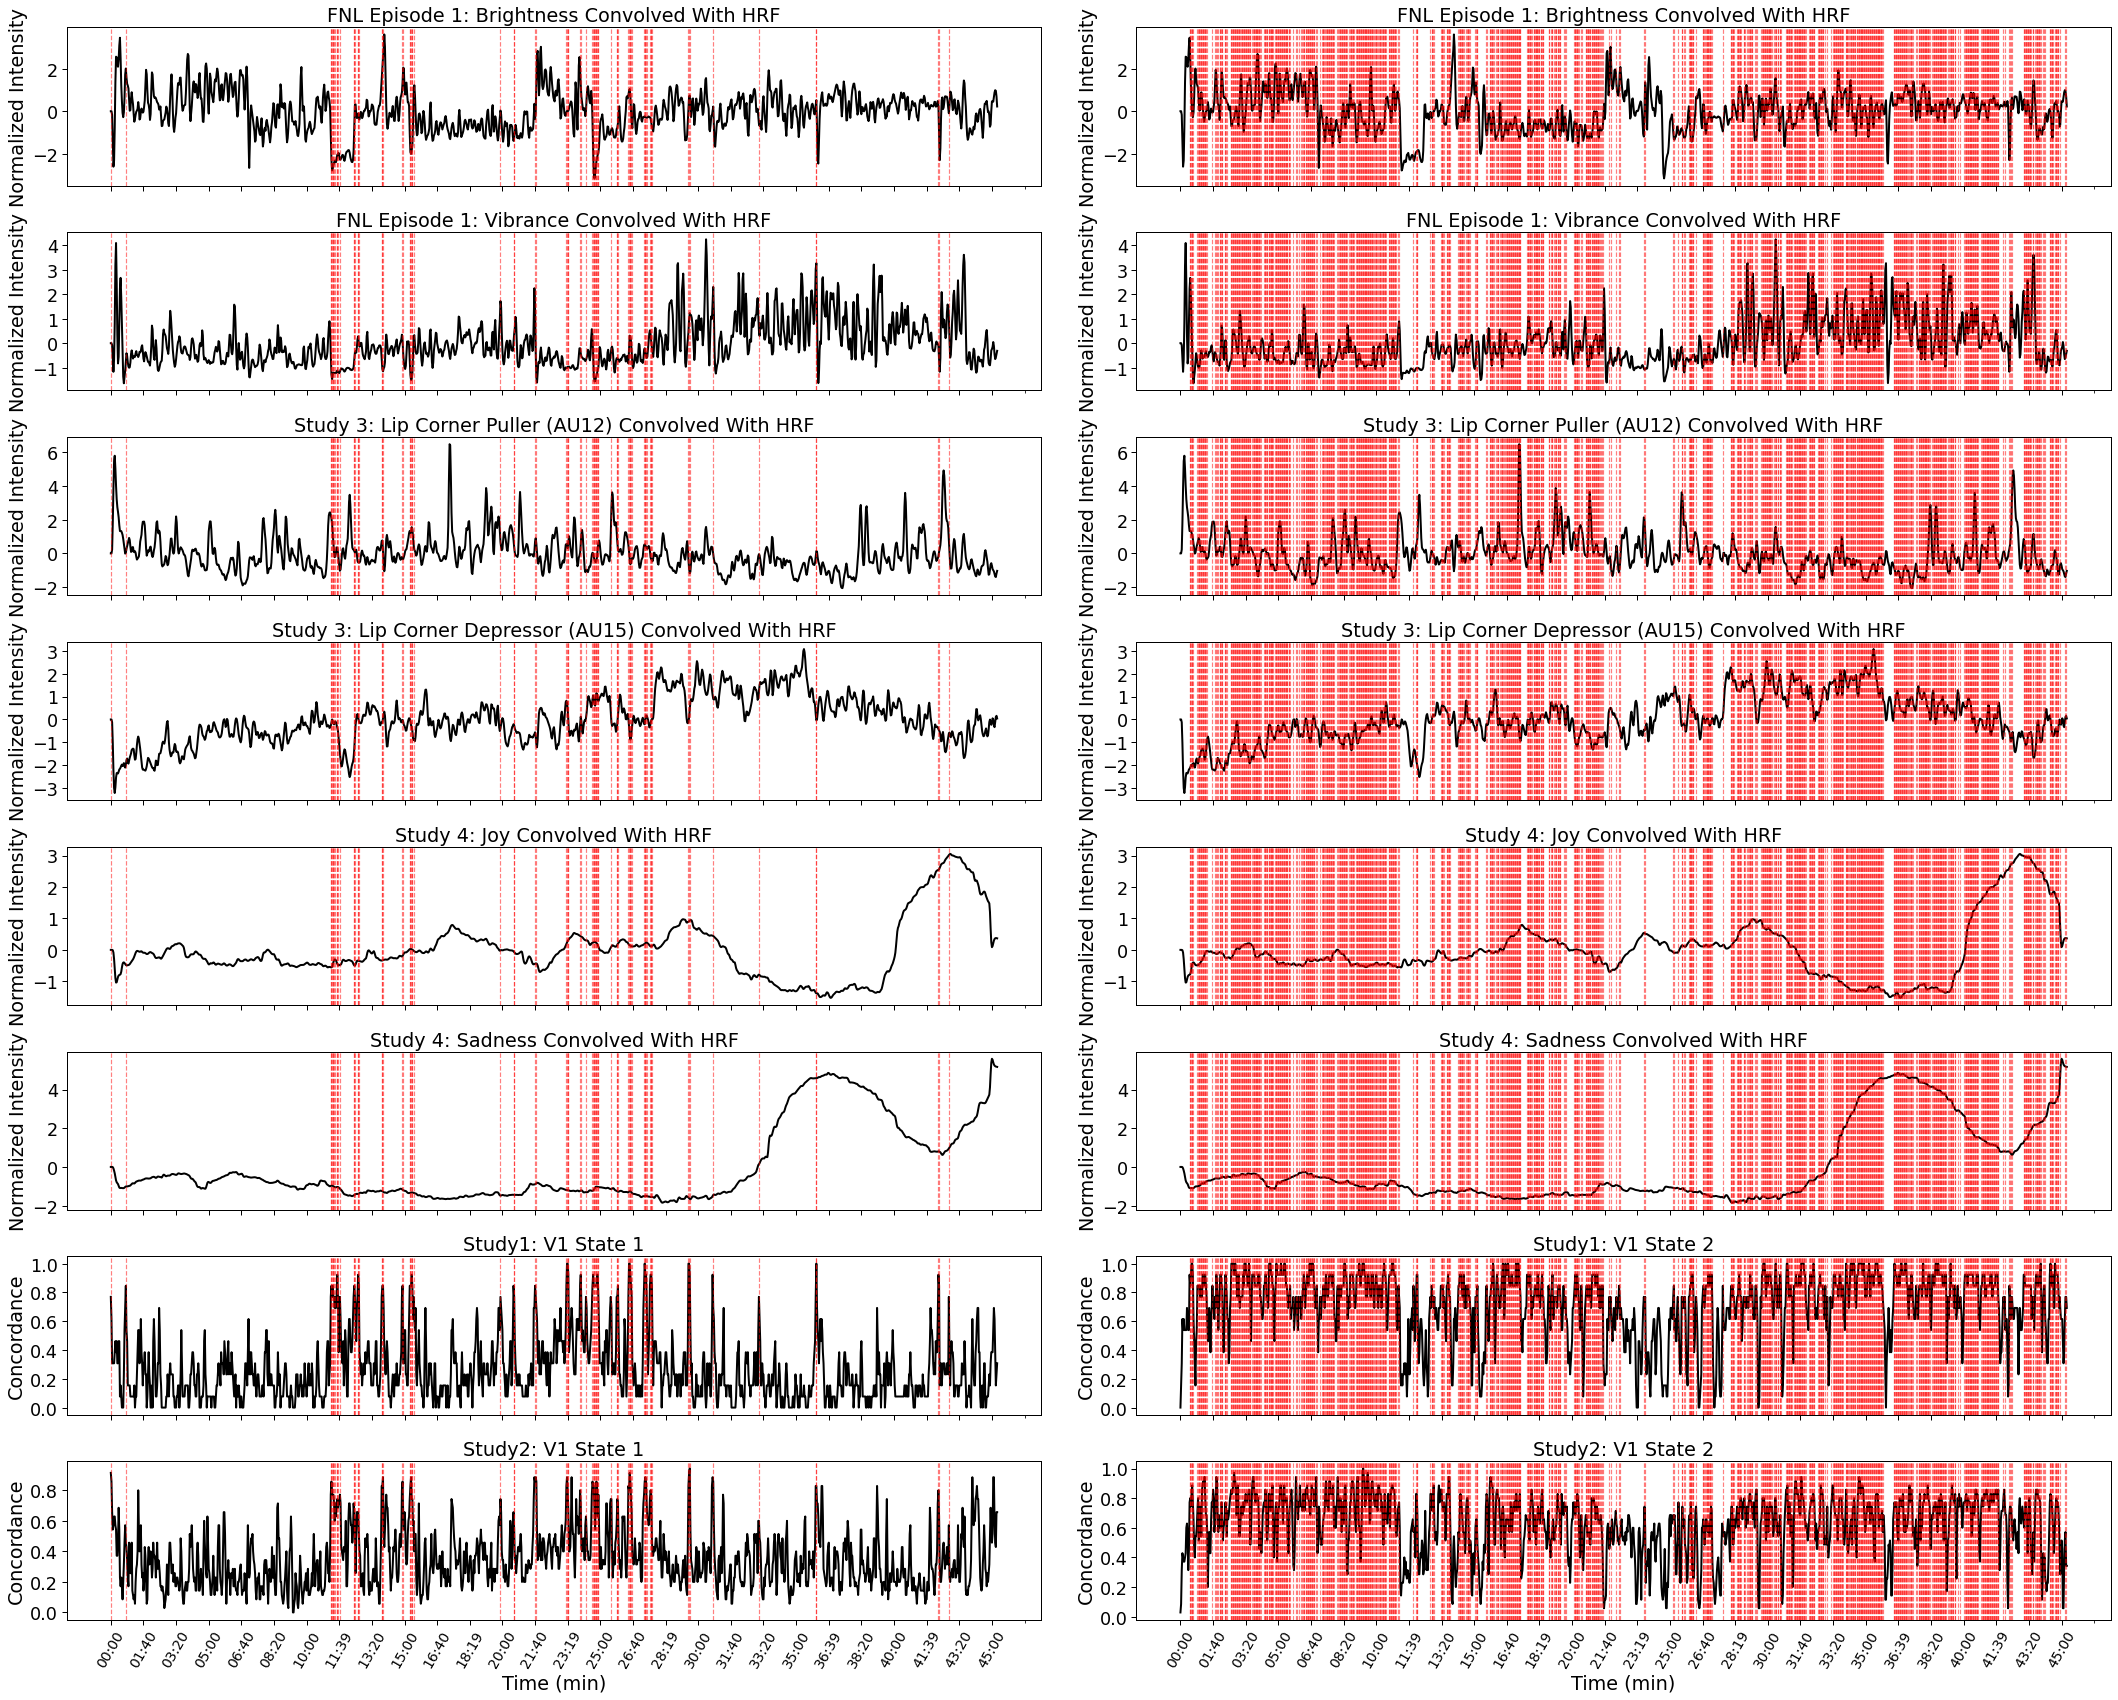

In [534]:

    
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'

thresh = 0.7
linewidth = 2

with sns.plotting_context(context='paper', font_scale=2):
    f,a = plt.subplots(nrows=8, ncols=2, figsize=(30,24), sharex=True)
    
    # State 1
    convolved_features['Brightness'].plot(ax=a[0,0], legend=False, color='black', linewidth=linewidth)
    convolved_features['Vibrance'].plot(ax=a[1,0], legend=False, color='black', linewidth=linewidth)
    convolved_features['AU12'].plot(ax=a[2,0], legend=False, color='black', linewidth=linewidth)
    convolved_features['AU15'].plot(ax=a[3,0], legend=False, color='black', linewidth=linewidth)
    convolved_features['Joy'].plot(ax=a[4,0], legend=False, color='black', linewidth=linewidth)
    convolved_features['Sadness'].plot(ax=a[5,0], legend=False, color='black', linewidth=linewidth)
    features[['Study1_ROI4_State_0']].plot(ax=a[6,0], legend=False, color='black', linewidth=linewidth)
    features[['Study2_ROI4_State_1']].plot(ax=a[7,0], legend=False, color='black', linewidth=linewidth)

    a[0,0].set_ylabel('Normalized Intensity')
    a[1,0].set_ylabel('Normalized Intensity')
    a[2,0].set_ylabel('Normalized Intensity')
    a[3,0].set_ylabel('Normalized Intensity')
    a[4,0].set_ylabel('Normalized Intensity')
    a[5,0].set_ylabel('Normalized Intensity')
    a[6,0].set_ylabel('Concordance')
    a[7,0].set_ylabel('Concordance')
  
    a[0,0].set_title('FNL Episode 1: Brightness Convolved With HRF')
    a[1,0].set_title('FNL Episode 1: Vibrance Convolved With HRF')
    a[2,0].set_title('Study 3: Lip Corner Puller (AU12) Convolved With HRF')
    a[3,0].set_title('Study 3: Lip Corner Depressor (AU15) Convolved With HRF')
    a[4,0].set_title('Study 4: Joy Convolved With HRF')
    a[5,0].set_title('Study 4: Sadness Convolved With HRF')
    a[6,0].set_title('Study1: V1 State 1')
    a[7,0].set_title('Study2: V1 State 1')

    a[7,0].set_xticks(range(0, convolved_features.shape[0], 50))
    a[7,0].set_xticklabels(rec_to_time(range(0, convolved_features.shape[0], 50), TR=2.0), rotation=60, fontsize=14)
    a[7,0].set_xlabel('Time (min)')

    for i in np.where(features[['Study1_ROI4_State_0']] > thresh)[0]:
        for j in range(8):
            a[j,0].axvline(i, color='red', alpha=.5, linestyle='--')
            
    # State 2
    convolved_features['Brightness'].plot(ax=a[0,1], legend=False, color='black', linewidth=linewidth)
    convolved_features['Vibrance'].plot(ax=a[1,1], legend=False, color='black', linewidth=linewidth)
    convolved_features['AU12'].plot(ax=a[2,1], legend=False, color='black', linewidth=linewidth)
    convolved_features['AU15'].plot(ax=a[3,1], legend=False, color='black', linewidth=linewidth)
    convolved_features['Joy'].plot(ax=a[4,1], legend=False, color='black', linewidth=linewidth)
    convolved_features['Sadness'].plot(ax=a[5,1], legend=False, color='black', linewidth=linewidth)
    features[['Study1_ROI4_State_1']].plot(ax=a[6,1], legend=False, color='black', linewidth=linewidth)
    features[['Study2_ROI4_State_0']].plot(ax=a[7,1], legend=False, color='black', linewidth=linewidth)

    a[0,1].set_ylabel('Normalized Intensity')
    a[1,1].set_ylabel('Normalized Intensity')
    a[2,1].set_ylabel('Normalized Intensity')
    a[3,1].set_ylabel('Normalized Intensity')
    a[4,1].set_ylabel('Normalized Intensity')
    a[5,1].set_ylabel('Normalized Intensity')
    a[6,1].set_ylabel('Concordance')
    a[7,1].set_ylabel('Concordance')
  
    a[0,1].set_title('FNL Episode 1: Brightness Convolved With HRF')
    a[1,1].set_title('FNL Episode 1: Vibrance Convolved With HRF')
    a[2,1].set_title('Study 3: Lip Corner Puller (AU12) Convolved With HRF')
    a[3,1].set_title('Study 3: Lip Corner Depressor (AU15) Convolved With HRF')
    a[4,1].set_title('Study 4: Joy Convolved With HRF')
    a[5,1].set_title('Study 4: Sadness Convolved With HRF')
    a[6,1].set_title('Study1: V1 State 2')
    a[7,1].set_title('Study2: V1 State 2')

    a[7,1].set_xticks(range(0, convolved_features.shape[0], 50))
    a[7,1].set_xticklabels(rec_to_time(range(0, convolved_features.shape[0], 50), TR=2.0), rotation=60, fontsize=14)
    a[7,1].set_xlabel('Time (min)')

    for i in np.where(features[['Study1_ROI4_State_1']] > thresh)[0]:
        for j in range(8):
            a[j,1].axvline(i, color='red', alpha=.5, linestyle='--')
            
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'Figures', 'FeatureExtraction', f'FNL_V1_Features_Convolved_threshold{thresh}.pdf'))
    plt.savefig(os.path.join(base_dir, 'Figures', 'FeatureExtraction', f'FNL_V1_Features_Convolved_threshold{thresh}.png'), dpi=150)


## Plot vmPFC Concordance with Convolved Features

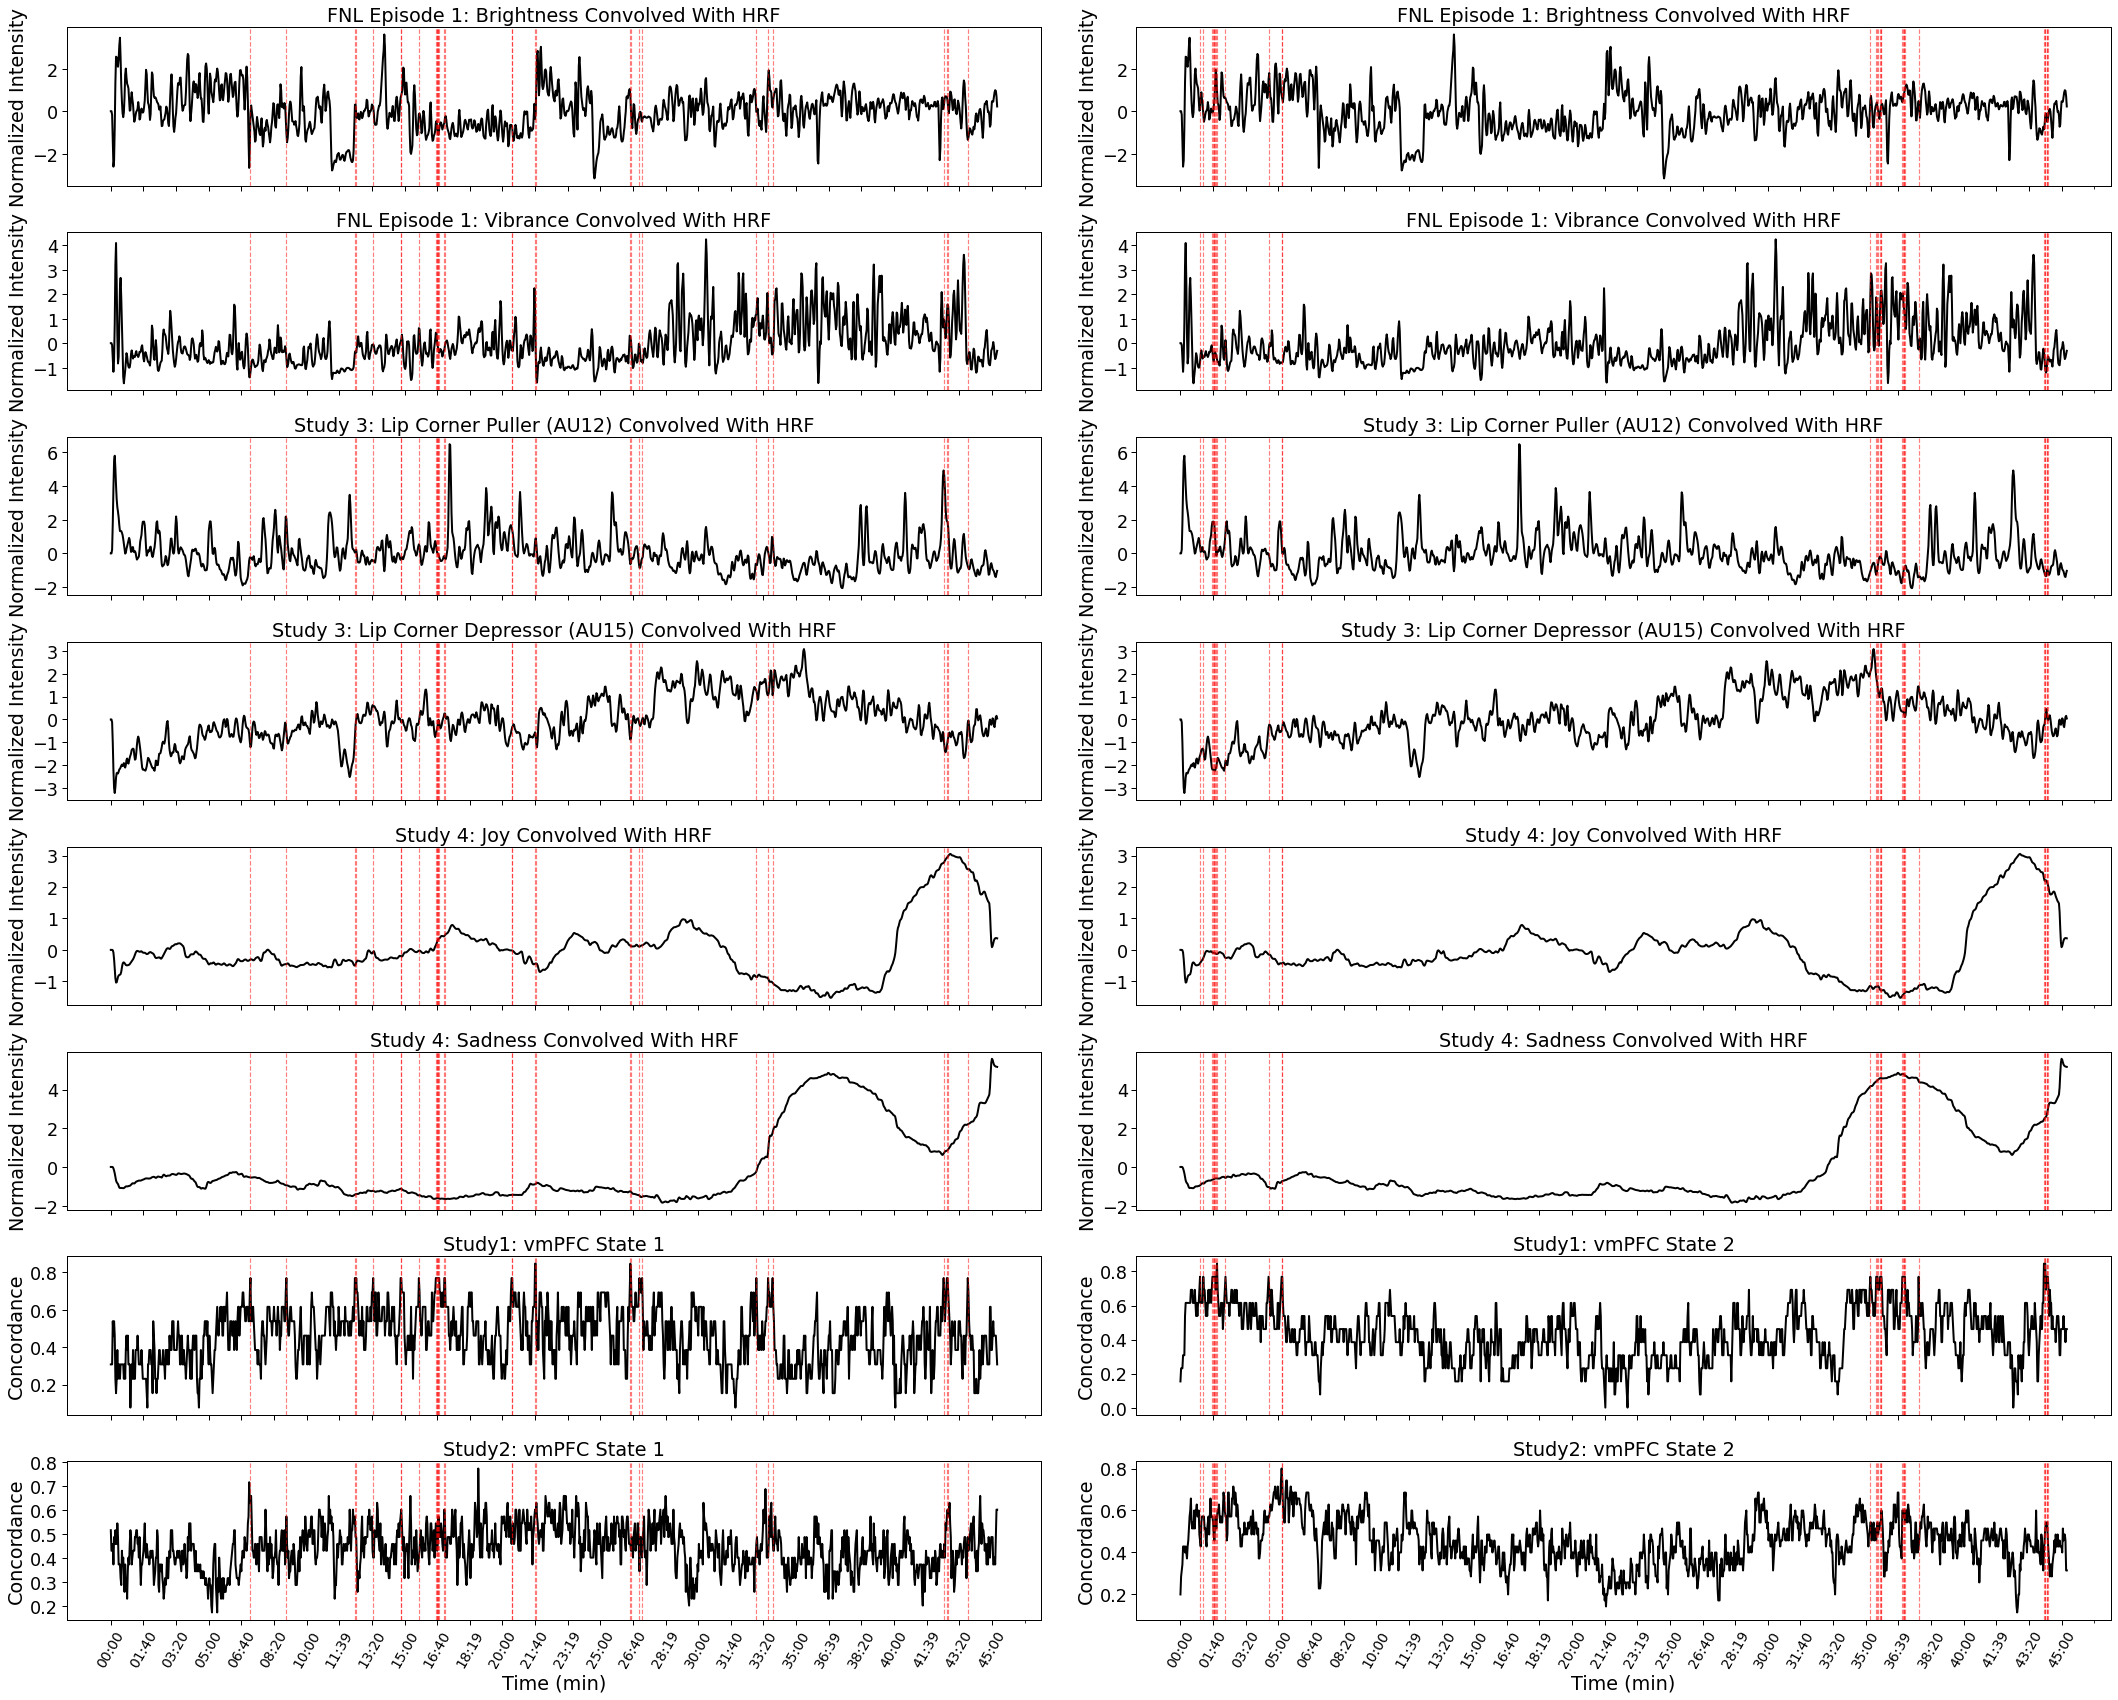

In [202]:
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'

thresh = 0.7
linewidth = 2

with sns.plotting_context(context='paper', font_scale=2):
    f,a = plt.subplots(nrows=8, ncols=2, figsize=(30,24), sharex=True)
    
    # State 1
    convolved_features['Brightness'].plot(ax=a[0,0], legend=False, color='black', linewidth=linewidth)
    convolved_features['Vibrance'].plot(ax=a[1,0], legend=False, color='black', linewidth=linewidth)
    convolved_features['AU12'].plot(ax=a[2,0], legend=False, color='black', linewidth=linewidth)
    convolved_features['AU15'].plot(ax=a[3,0], legend=False, color='black', linewidth=linewidth)
    convolved_features['Joy'].plot(ax=a[4,0], legend=False, color='black', linewidth=linewidth)
    convolved_features['Sadness'].plot(ax=a[5,0], legend=False, color='black', linewidth=linewidth)
    features[['Study1_ROI32_State_3']].plot(ax=a[6,0], legend=False, color='black', linewidth=linewidth)
    features[['Study2_ROI32_State_3']].plot(ax=a[7,0], legend=False, color='black', linewidth=linewidth)

    a[0,0].set_ylabel('Normalized Intensity')
    a[1,0].set_ylabel('Normalized Intensity')
    a[2,0].set_ylabel('Normalized Intensity')
    a[3,0].set_ylabel('Normalized Intensity')
    a[4,0].set_ylabel('Normalized Intensity')
    a[5,0].set_ylabel('Normalized Intensity')
    a[6,0].set_ylabel('Concordance')
    a[7,0].set_ylabel('Concordance')
  
    a[0,0].set_title('FNL Episode 1: Brightness Convolved With HRF')
    a[1,0].set_title('FNL Episode 1: Vibrance Convolved With HRF')
    a[2,0].set_title('Study 3: Lip Corner Puller (AU12) Convolved With HRF')
    a[3,0].set_title('Study 3: Lip Corner Depressor (AU15) Convolved With HRF')
    a[4,0].set_title('Study 4: Joy Convolved With HRF')
    a[5,0].set_title('Study 4: Sadness Convolved With HRF')
    a[6,0].set_title('Study1: vmPFC State 1')
    a[7,0].set_title('Study2: vmPFC State 1')

    a[7,0].set_xticks(range(0, convolved_features.shape[0], 50))
    a[7,0].set_xticklabels(rec_to_time(range(0, convolved_features.shape[0], 50), TR=2.0), rotation=60, fontsize=14)
    a[7,0].set_xlabel('Time (min)')

    for i in np.where(features[['Study1_ROI32_State_3']] > thresh)[0]:
        for j in range(8):
            a[j,0].axvline(i, color='red', alpha=.5, linestyle='--')

    # State 2
    convolved_features['Brightness'].plot(ax=a[0,1], legend=False, color='black', linewidth=linewidth)
    convolved_features['Vibrance'].plot(ax=a[1,1], legend=False, color='black', linewidth=linewidth)
    convolved_features['AU12'].plot(ax=a[2,1], legend=False, color='black', linewidth=linewidth)
    convolved_features['AU15'].plot(ax=a[3,1], legend=False, color='black', linewidth=linewidth)
    convolved_features['Joy'].plot(ax=a[4,1], legend=False, color='black', linewidth=linewidth)
    convolved_features['Sadness'].plot(ax=a[5,1], legend=False, color='black', linewidth=linewidth)
    features[['Study1_ROI32_State_0']].plot(ax=a[6,1], legend=False, color='black', linewidth=linewidth)
    features[['Study2_ROI32_State_1']].plot(ax=a[7,1], legend=False, color='black', linewidth=linewidth)

    a[0,1].set_ylabel('Normalized Intensity')
    a[1,1].set_ylabel('Normalized Intensity')
    a[2,1].set_ylabel('Normalized Intensity')
    a[3,1].set_ylabel('Normalized Intensity')
    a[4,1].set_ylabel('Normalized Intensity')
    a[5,1].set_ylabel('Normalized Intensity')
    a[6,1].set_ylabel('Concordance')
    a[7,1].set_ylabel('Concordance')
  
    a[0,1].set_title('FNL Episode 1: Brightness Convolved With HRF')
    a[1,1].set_title('FNL Episode 1: Vibrance Convolved With HRF')
    a[2,1].set_title('Study 3: Lip Corner Puller (AU12) Convolved With HRF')
    a[3,1].set_title('Study 3: Lip Corner Depressor (AU15) Convolved With HRF')
    a[4,1].set_title('Study 4: Joy Convolved With HRF')
    a[5,1].set_title('Study 4: Sadness Convolved With HRF')
    a[6,1].set_title('Study1: vmPFC State 2')
    a[7,1].set_title('Study2: vmPFC State 2')

    a[7,1].set_xticks(range(0, convolved_features.shape[0], 50))
    a[7,1].set_xticklabels(rec_to_time(range(0, convolved_features.shape[0], 50), TR=2.0), rotation=60, fontsize=14)
    a[7,1].set_xlabel('Time (min)')

    for i in np.where(features[['Study1_ROI32_State_0']] > thresh)[0]:
        for j in range(8):
            a[j,1].axvline(i, color='red', alpha=.5, linestyle='--')    
    
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'Figures', 'FeatureExtraction', f'FNL_vmPFC_Features_Convolved_threshold{thresh}.pdf'))
    plt.savefig(os.path.join(base_dir, 'Figures', 'FeatureExtraction', f'FNL_vmPFC_Features_Convolved_threshold{thresh}.png'), dpi=150)


## Plot PCC Concordance with Convolved Features


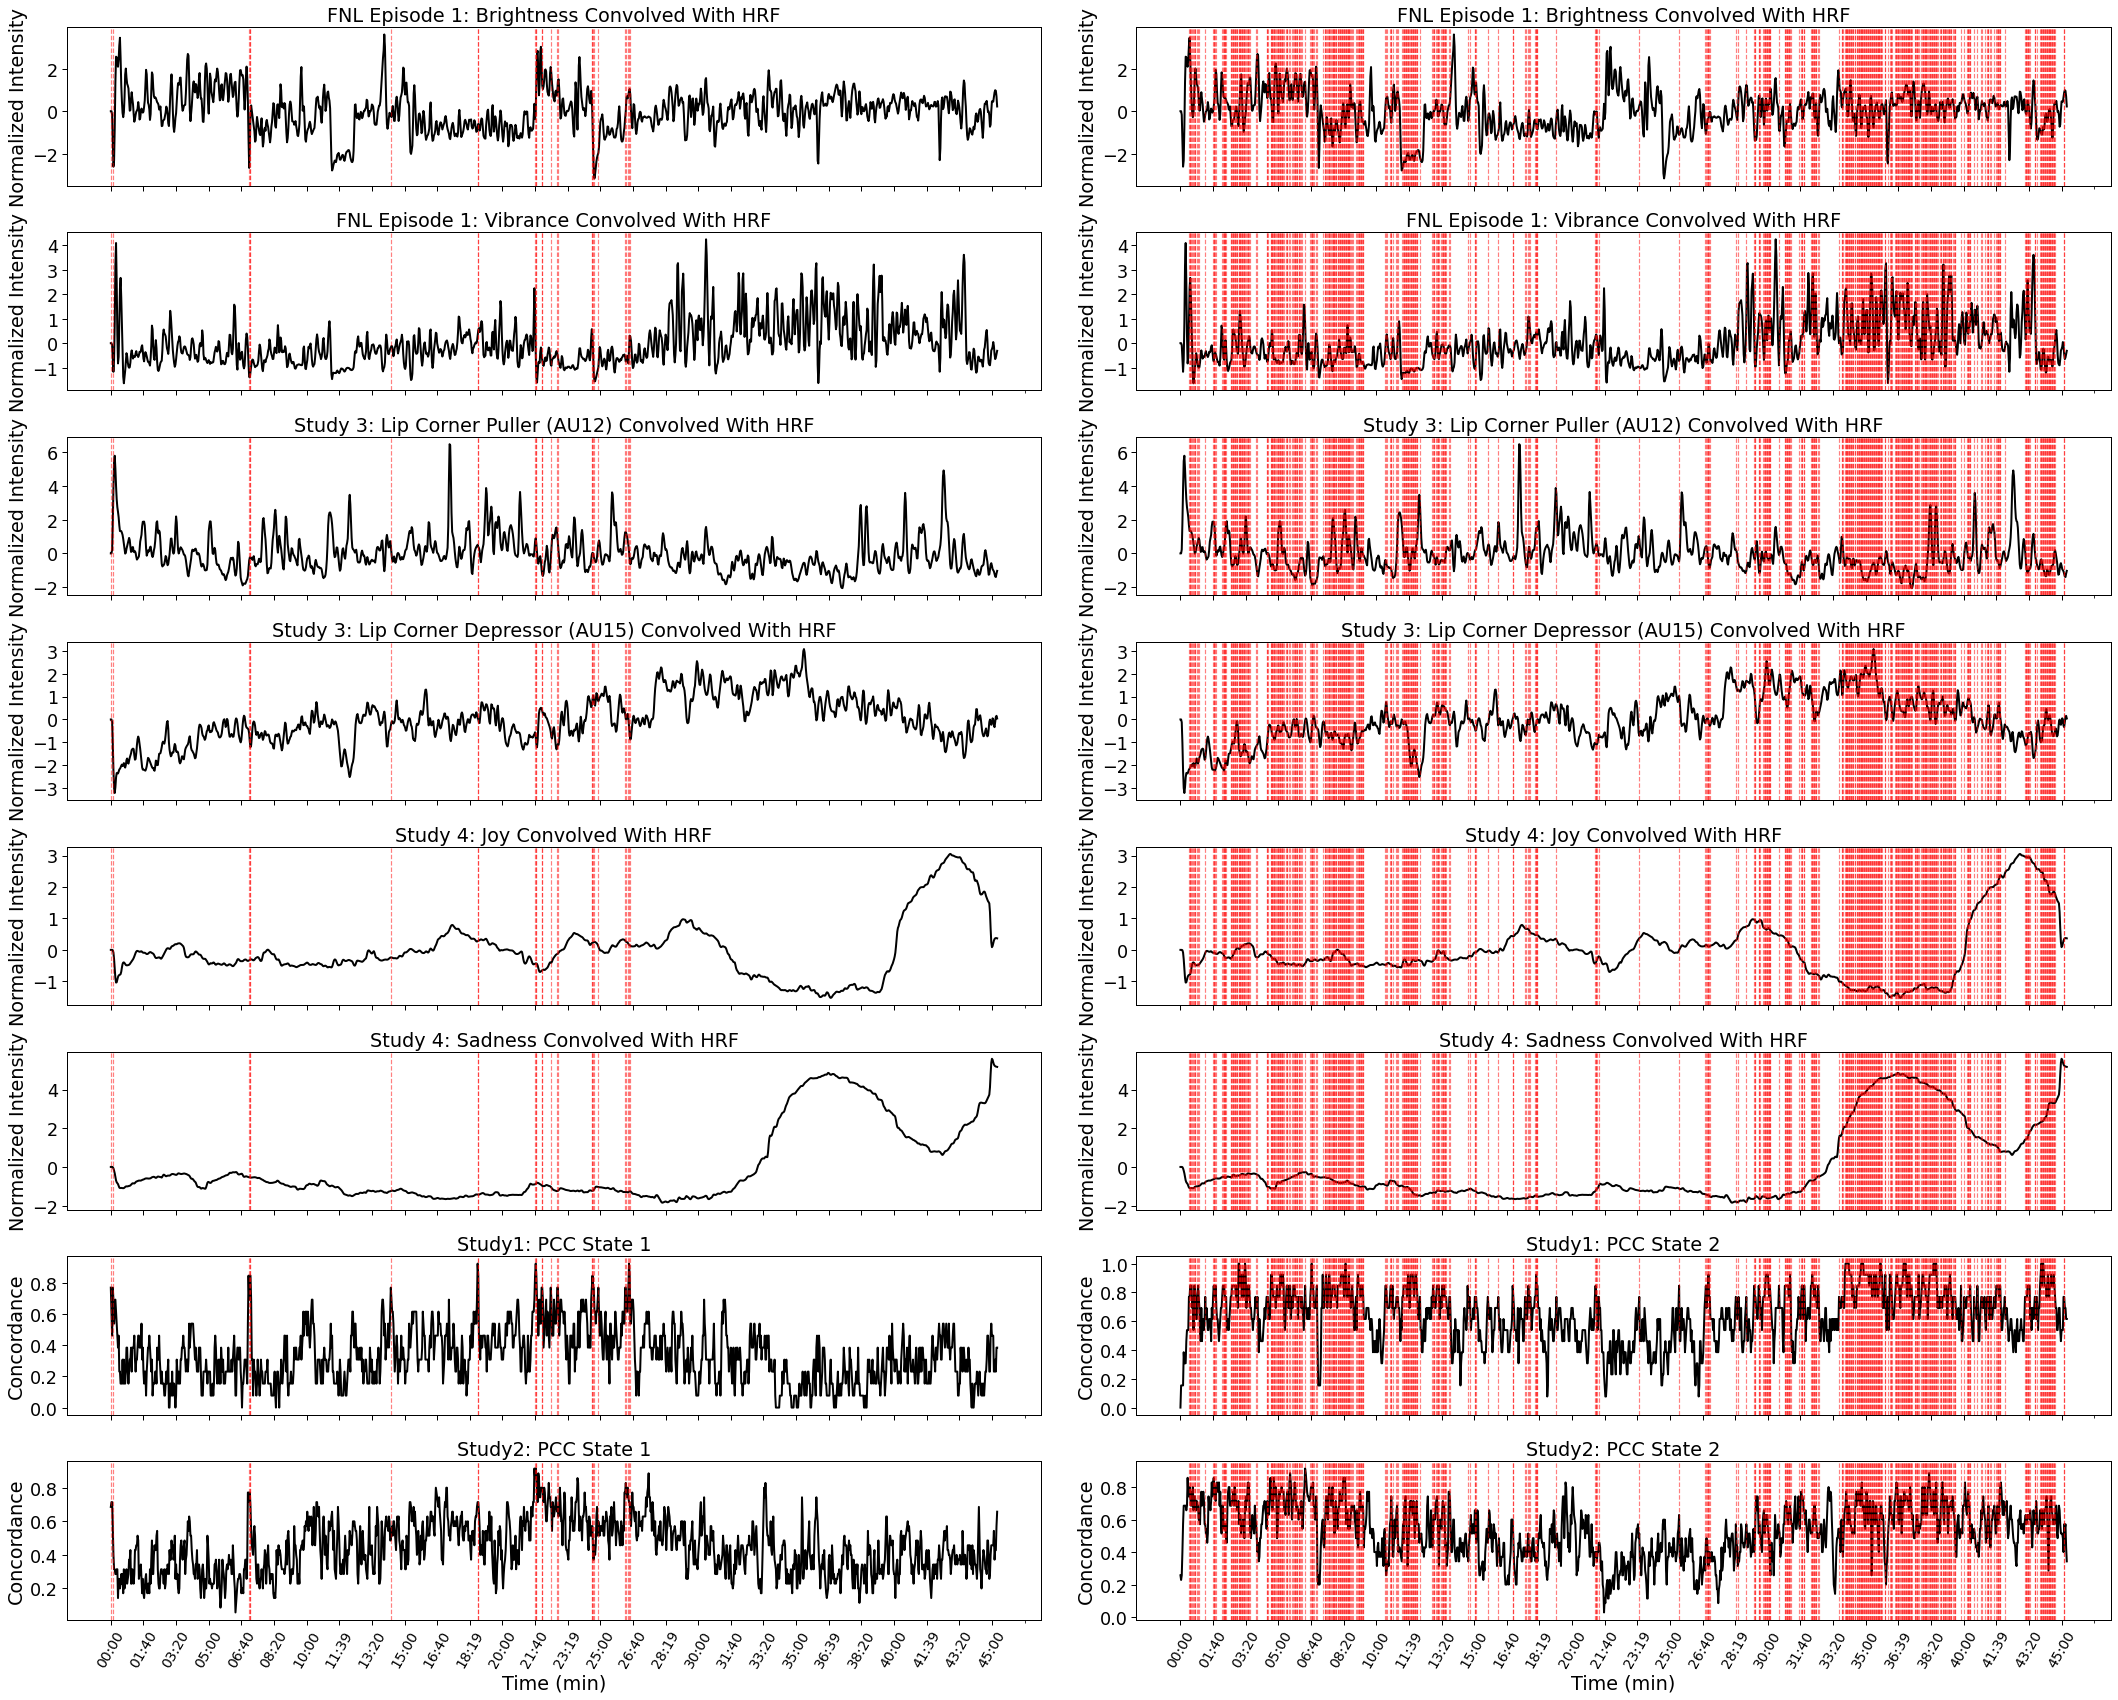

In [533]:
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'

thresh = 0.7
linewidth = 2

with sns.plotting_context(context='paper', font_scale=2):
    f,a = plt.subplots(nrows=8, ncols=2, figsize=(30,24), sharex=True)
    
    # State 1
    convolved_features['Brightness'].plot(ax=a[0,0], legend=False, color='black', linewidth=linewidth)
    convolved_features['Vibrance'].plot(ax=a[1,0], legend=False, color='black', linewidth=linewidth)
    convolved_features['AU12'].plot(ax=a[2,0], legend=False, color='black', linewidth=linewidth)
    convolved_features['AU15'].plot(ax=a[3,0], legend=False, color='black', linewidth=linewidth)
    convolved_features['Joy'].plot(ax=a[4,0], legend=False, color='black', linewidth=linewidth)
    convolved_features['Sadness'].plot(ax=a[5,0], legend=False, color='black', linewidth=linewidth)
    features[['Study1_ROI19_State_0']].plot(ax=a[6,0], legend=False, color='black', linewidth=linewidth)
    features[['Study2_ROI19_State_2']].plot(ax=a[7,0], legend=False, color='black', linewidth=linewidth)

    a[0,0].set_ylabel('Normalized Intensity')
    a[1,0].set_ylabel('Normalized Intensity')
    a[2,0].set_ylabel('Normalized Intensity')
    a[3,0].set_ylabel('Normalized Intensity')
    a[4,0].set_ylabel('Normalized Intensity')
    a[5,0].set_ylabel('Normalized Intensity')
    a[6,0].set_ylabel('Concordance')
    a[7,0].set_ylabel('Concordance')
  
    a[0,0].set_title('FNL Episode 1: Brightness Convolved With HRF')
    a[1,0].set_title('FNL Episode 1: Vibrance Convolved With HRF')
    a[2,0].set_title('Study 3: Lip Corner Puller (AU12) Convolved With HRF')
    a[3,0].set_title('Study 3: Lip Corner Depressor (AU15) Convolved With HRF')
    a[4,0].set_title('Study 4: Joy Convolved With HRF')
    a[5,0].set_title('Study 4: Sadness Convolved With HRF')
    a[6,0].set_title('Study1: PCC State 1')
    a[7,0].set_title('Study2: PCC State 1')

    a[7,0].set_xticks(range(0, convolved_features.shape[0], 50))
    a[7,0].set_xticklabels(rec_to_time(range(0, convolved_features.shape[0], 50), TR=2.0), rotation=60, fontsize=14)
    a[7,0].set_xlabel('Time (min)')

    for i in np.where(features[['Study1_ROI19_State_0']] > thresh)[0]:
        for j in range(8):
            a[j,0].axvline(i, color='red', alpha=.5, linestyle='--')
            
    # State 2
    convolved_features['Brightness'].plot(ax=a[0,1], legend=False, color='black', linewidth=linewidth)
    convolved_features['Vibrance'].plot(ax=a[1,1], legend=False, color='black', linewidth=linewidth)
    convolved_features['AU12'].plot(ax=a[2,1], legend=False, color='black', linewidth=linewidth)
    convolved_features['AU15'].plot(ax=a[3,1], legend=False, color='black', linewidth=linewidth)
    convolved_features['Joy'].plot(ax=a[4,1], legend=False, color='black', linewidth=linewidth)
    convolved_features['Sadness'].plot(ax=a[5,1], legend=False, color='black', linewidth=linewidth)
    features[['Study1_ROI19_State_1']].plot(ax=a[6,1], legend=False, color='black', linewidth=linewidth)
    features[['Study2_ROI19_State_0']].plot(ax=a[7,1], legend=False, color='black', linewidth=linewidth)

    a[0,1].set_ylabel('Normalized Intensity')
    a[1,1].set_ylabel('Normalized Intensity')
    a[2,1].set_ylabel('Normalized Intensity')
    a[3,1].set_ylabel('Normalized Intensity')
    a[4,1].set_ylabel('Normalized Intensity')
    a[5,1].set_ylabel('Normalized Intensity')
    a[6,1].set_ylabel('Concordance')
    a[7,1].set_ylabel('Concordance')
  
    a[0,1].set_title('FNL Episode 1: Brightness Convolved With HRF')
    a[1,1].set_title('FNL Episode 1: Vibrance Convolved With HRF')
    a[2,1].set_title('Study 3: Lip Corner Puller (AU12) Convolved With HRF')
    a[3,1].set_title('Study 3: Lip Corner Depressor (AU15) Convolved With HRF')
    a[4,1].set_title('Study 4: Joy Convolved With HRF')
    a[5,1].set_title('Study 4: Sadness Convolved With HRF')
    a[6,1].set_title('Study1: PCC State 2')
    a[7,1].set_title('Study2: PCC State 2')

    a[7,1].set_xticks(range(0, convolved_features.shape[0], 50))
    a[7,1].set_xticklabels(rec_to_time(range(0, convolved_features.shape[0], 50), TR=2.0), rotation=60, fontsize=14)
    a[7,1].set_xlabel('Time (min)')

    for i in np.where(features[['Study1_ROI19_State_1']] > thresh)[0]:
        for j in range(8):
            a[j,1].axvline(i, color='red', alpha=.5, linestyle='--')

    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'Figures', 'FeatureExtraction', f'FNL_PCC_Features_Convolved_threshold{thresh}.pdf'))
    plt.savefig(os.path.join(base_dir, 'Figures', 'FeatureExtraction', f'FNL_PCC_Features_Convolved_threshold{thresh}.png'), dpi=150)
